In [1]:
import json
import pandas as pd
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import svm
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from sklearn import linear_model
from collections import defaultdict
import scikits.bootstrap as boot

# Utils

In [2]:
def get_ids(df):
    conversations = df.values.tolist()
    conversation_ids = []
    for conv in conversations:
        cur_conv = json.loads(conv)
        conversation_ids.append(list(cur_conv.keys())[0])
    return conversation_ids

In [3]:
def get_action_lst(conv):

    cur_conv = json.loads(conv)
    return list(cur_conv.keys())[0]

In [4]:
def get_paired_action_lst(conv):
    conv = json.loads(conv)
    cur_conv1 = conv['conversation1']
    cur_conv2 = conv['conversation2']
    return list(cur_conv1.keys())[0], list(cur_conv2.keys())[0]

In [5]:
def non_readable_or_not_sure(df):
    df['not_English'] = (df['na'] == True)
    df['not_sure_toxicity'] = (df['toxic'] == -1)
    non_english = pd.DataFrame({'not_readable': df.groupby('_unit_id')['not_English'].mean() >=0.5}).reset_index()
    non_english = non_english[non_english['not_readable'] == True]['_unit_id'].values.tolist()
    not_sure_toxicity = pd.DataFrame({'not_sure_toxicity': df.groupby('_unit_id')['not_sure_toxicity'].mean() >= 0.5}).reset_index()
    not_sure_toxicity = not_sure_toxicity[not_sure_toxicity['not_sure_toxicity'] == True]['_unit_id'].values.tolist()
    return non_english + not_sure_toxicity

In [6]:
def attacker_in_conv(conv):
    actions = conv['action_feature']
    end_time = max([a['timestamp_in_sec'] for a in actions])
    attacker = None
    for a in actions:
        if a['timestamp_in_sec'] == end_time:
            attacker = a['user_text']
    for a in actions:
        if a['timestamp_in_sec'] < end_time and a['user_text'] == attacker:
            return True
    return False

In [7]:
constraint = "constraintA+B"
job_suffix = 'constraintsAB_v017'

In [79]:
constraint = "constraintB"
job_suffix = 'constraintB_v018'

In [9]:
cleaned_data = []
with open('/scratch/wiki_dumps/paired_conversations/%s/data/all.json'%constraint) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        cleaned_data.append([conv_id, clss, conversation])
print(len(cleaned_data))

1844


# Paired Annotation

In [42]:
#filename = '/scratch/wiki_dumps/annotated/paired_human_annotation.csv'
filename = '/scratch/wiki_dumps/annotated/paired_fix.csv'
with open(filename) as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

df['label'] = df.apply(lambda x: x['future_toxic'] -1, axis=1)
df['toxic_label'] = df.apply(lambda x: x['now_toxic'] -1 if x['now_toxic'] == 1 or x['now_toxic'] == 2 else -1, axis=1)

human_labels = pd.DataFrame({'label': df.groupby('_unit_id')['label'].mean() > 0.5, \
                            'toxic_label': df[df['toxic_label'] >= 0].groupby('_unit_id')['label'].mean() > 0.5}).\
            reset_index()
human_labels['label'] = human_labels['label'].apply(lambda x: int(x))
print(len(human_labels[pd.isnull(human_labels['toxic_label'])]), len(human_labels))
human_labels = human_labels.fillna(0)
human_labels['toxic_label'] = human_labels['toxic_label'].apply(lambda x: int(x))


unit_ids = df[['_unit_id','conversations']].values.tolist()

id_conv_mapping = {}
for unit_id in unit_ids:
    curid, conv = unit_id
    id_conv_mapping[curid] = get_paired_action_lst(conv)
unit_ids = id_conv_mapping

data = []
appeared = {}
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    page_title = conversation['action_feature'][0]['page_title']
    if clss: continue
    for curid, conv in id_conv_mapping.items():
        if conv[0] in idlist:
            data.append({'_unit_id': curid, 'bad_conv': 0, 'page_title': page_title, 'bad_conv_id': conv_id})
            appeared[conv_id] = True
        elif conv[1] in idlist:
            data.append({'_unit_id': curid, 'bad_conv': 1, 'page_title': page_title, 'bad_conv_id': conv_id})

human_df = pd.DataFrame(data).set_index('_unit_id')
human_df = human_df.join(human_labels.set_index('_unit_id'))

human_df['accuracy'] = human_df.apply(lambda x: int(x['label'] == x['bad_conv']), axis=1)
human_df['toxic_accuracy'] = human_df.apply(lambda x: int(x['toxic_label'] == x['bad_conv']), axis=1)

225 534


In [43]:
with open('/scratch/wiki_dumps/annotated/paired_accuracy_ver1.csv') as f:
     human_df_ver1 = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

In [44]:
bads = human_df['bad_conv_id'].values.tolist()
human_df_ver1 = human_df_ver1[~(human_df_ver1['bad_conv_id'].isin(bads))]
human_df = pd.concat([human_df, human_df_ver1])

scores = human_df.groupby('page_title')['accuracy'].mean().reset_index()
print(np.mean(scores['accuracy']), scipy.stats.sem(scores['accuracy']), \
np.mean(scores['accuracy']) + scipy.stats.sem(scores['accuracy']) * 1.96)

toxic_scores = human_df.groupby('page_title')['toxic_accuracy'].mean().reset_index()
print(np.mean(toxic_scores['toxic_accuracy']), scipy.stats.sem(toxic_scores['toxic_accuracy']))

In [82]:
with open('human.json', 'w') as f:
    json.dump(scores['accuracy'].values.tolist(), f)

In [52]:
with open('human_p.json', 'w') as f:
    json.dump(toxic_scores['toxic_accuracy'].values.tolist(), f)

# Toxicity in Context

In [102]:
with open('/scratch/wiki_dumps/annotated/toxicity_in_context_constraintAB_v019.csv') as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

In [110]:
toxic_annotations = df[df['toxic'] >= 0]
toxic_comments = pd.DataFrame({'toxic': toxic_annotations.groupby('_unit_id')['toxic'].mean() >= 0.5}).\
            reset_index()

In [111]:
print(len(toxic_comments[toxic_comments['toxic'] == True]) / len(toxic_comments))

0.24272588055130168


# JOB 1

In [9]:
filename = '/scratch/wiki_dumps/annotated/job1_%s.csv'%job_suffix
#'/scratch/wiki_dumps/annotated/job1_%s.csv'%('fix')
with open(filename) as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

toxicity = df[df['toxic'] >= 0]
toxic_before = pd.DataFrame({'toxic_before': toxicity.groupby('_unit_id')['toxic'].mean() >= 0.5}).\
            reset_index()
toxic_before = toxic_before[toxic_before['toxic_before'] == True]['_unit_id'].values.tolist()
_excluded = list(set(non_readable_or_not_sure(df) + toxic_before))
annotated = set(get_ids(df['conversations']))
excluded_1 = set(get_ids(df[df['_unit_id'].isin(_excluded)]['conversations']))

annotations = pd.DataFrame({'not_toxic': df[df['toxic'] == 0].groupby('_unit_id').size(), \
                              'toxic': df[df['toxic'] == 1].groupby('_unit_id').size(), \
                              'not_sure_toxic': df[df['toxic'] < 0].groupby('_unit_id').size(), \
                              'not_disagree':  df[df['disagreement'] == 0].groupby('_unit_id').size(), \
                              'disagree': df[df['disagreement'] == 1].groupby('_unit_id').size(), \
                              'not_sure_disagree': df[df['disagreement'] < 0].groupby('_unit_id').size(), 
                               'very_unlikey2toxic': df[df['lead_to_toxic'] == -2].groupby('_unit_id').size(), \
                              'unlikely2toxic': df[df['lead_to_toxic'] == -1].groupby('_unit_id').size(), \
                               'likely2toxic': df[df['lead_to_toxic'] == 1].groupby('_unit_id').size(), \
                               'very_likely2toxic': df[df['lead_to_toxic'] == 2].groupby('_unit_id').size(), \
                              'not_sure2toxic': df[np.isnan(df['lead_to_toxic'])].groupby('_unit_id').size(), \
                               'no_annotators': df.groupby('_unit_id').size(), \
                              'toxicity_score' : df[df['toxic'] > 0].groupby('_unit_id')['toxic'].mean(), \
                              'lead_to_toxic_score': df[~pd.isnull(df['lead_to_toxic'])].groupby('_unit_id')['lead_to_toxic'].mean(), \
                              'disagree_score' : df[df['disagreement'] > 0].groupby('_unit_id')['disagreement'].mean()}).reset_index()

annotations = annotations.fillna(int(0))

unit_ids = df[['_unit_id','conversations']].values.tolist()

id_conv_mapping = {}
for unit_id in unit_ids:
    curid, conv = unit_id
    id_conv_mapping[curid] = get_action_lst(conv)
unit_ids = id_conv_mapping

data = []
appeared = {}
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    page_title = conversation['action_feature'][0]['page_title']
    if clss:
        matched_id = conversation['action_feature'][0]['bad_conversation_id']
    else:
        matched_id = conversation['action_feature'][0]['good_conversation_id']
    for curid, conv in id_conv_mapping.items():
        if conv in idlist and not(conv_id in appeared):
            data.append({'_unit_id': curid, 'conv_id': conv_id, 'matched_id': matched_id, \
                         'class' : clss, 'page_title': page_title})
            appeared[conv_id] = True

conv_df = pd.DataFrame(data).set_index('_unit_id')
conv_df = conv_df.join(annotations.set_index('_unit_id')).set_index('conv_id')

In [55]:
with open('/scratch/wiki_dumps/annotated/job1_ver1.csv', 'w') as f:
     conv_df.to_csv(f, encoding = 'utf-8', quoting=csv.QUOTE_ALL)

In [57]:
with open('/scratch/wiki_dumps/annotated/job1_ver1.csv') as f:
     conv_df_ver1 = pd.read_csv(f, encoding = 'utf-8', index_col=0,  quoting=csv.QUOTE_ALL)

In [58]:
fix = list(set(conv_df_ver1.index.values) - set(conv_df.index.values))

conv_df_ver1 = conv_df_ver1.ix[fix]

conv_df = pd.concat([conv_df_ver1, conv_df])

/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [37]:
with open('to_annotate.json', 'w') as w:
    json.dump(conv_df['conv_id'].values.tolist(), w)

In [38]:
# Each Conversation is annotated by 5~22 workers JOB1

# JOB 2

In [20]:
filename ='/scratch/wiki_dumps/annotated/job2_%s.csv'%('fix') 
#'/scratch/wiki_dumps/annotated/job2_%s.csv'%('fix')
with open(filename) as f:
     df = pd.read_csv(f, encoding = 'utf-8', index_col=None, quoting=csv.QUOTE_ALL)

#_excluded = list(set(non_readable_or_not_sure(df)))
#excluded_2 = set(get_ids(df[df['_unit_id'].isin(_excluded)]['conversations']))
#excluded = (excluded_1 | excluded_2)

df['conv_id'] = df.apply(lambda x: list(json.loads(x['conversations']).keys())[0], axis=1)

toxicity = df[df['toxic'] >= 0]
toxic = pd.DataFrame({'toxic': toxicity.groupby('_unit_id')['toxic'].mean() >= 0.5}).reset_index()
bad_convs = toxic[toxic['toxic'] == True]['_unit_id'].values.tolist()
bad_conversations = set(get_ids(df[df['_unit_id'].isin(bad_convs)]['conversations']))

df['disagrees'] = df.apply(lambda x: 0 if pd.isnull(x['disagreement']) else 1, axis=1)

annotations = pd.DataFrame({'not_toxic_job2': df[df['toxic'] == 0].groupby('_unit_id').size(), \
                            'toxic_job2': df[df['toxic'] == 1].groupby('_unit_id').size(), \
                            'not_sure_toxic_job2': df[df['toxic'] < 0].groupby('_unit_id').size(), \
                            'not_disagree_job2':  df[df['disagrees'] == 0].groupby('_unit_id').size(), \
                            'disagree_job2': df[df['disagrees'] == 1].groupby('_unit_id').size(), \
                            'no_annotators_job2': df.groupby('_unit_id').size()}).reset_index()

unit_ids = df[['_unit_id','conversations']].values.tolist()

id_conv_mapping = {}
for unit_id in unit_ids:
    curid, conv = unit_id
    id_conv_mapping[curid] = get_action_lst(conv)
unit_ids = id_conv_mapping

data = []
appeared = {}
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    for curid, conv in id_conv_mapping.items():
        if conv in idlist and not(conv_id in appeared):
            data.append({'_unit_id': curid, 'conv_id': conv_id})
            appeared[conv_id] = True

after_conv_df = pd.DataFrame(data).set_index('_unit_id')

after_conv_df = after_conv_df.join(annotations.set_index('_unit_id')).set_index('conv_id')

In [11]:
with open('/scratch/wiki_dumps/annotated/job2_ver1.csv', 'w') as f:
     after_conv_df.to_csv(f, encoding = 'utf-8', quoting=csv.QUOTE_ALL)

In [15]:
with open('/scratch/wiki_dumps/annotated/job2_ver1.csv') as f:
     after_conv_df_ver1 = pd.read_csv(f, encoding = 'utf-8', index_col=0, quoting=csv.QUOTE_ALL)

In [38]:
fix = list(set(after_conv_df_ver1.index.values) - set(after_conv_df.index.values))

after_conv_df_ver1 = after_conv_df_ver1.ix[fix]

after_conv_df = pd.concat([after_conv_df_ver1, after_conv_df])

In [34]:
conv_df = conv_df.join(after_conv_df)

In [ ]:
len(conv_df)

# Not Paired Performance

In [35]:
conv_df.columns

Index(['class', 'conv_id', 'matched_id', 'page_title', 'disagree',
       'disagree_score', 'lead_to_toxic_score', 'likely2toxic',
       'no_annotators', 'not_disagree', 'not_sure2toxic', 'not_sure_disagree',
       'not_sure_toxic', 'not_toxic', 'toxic', 'toxicity_score',
       'unlikely2toxic', 'very_likely2toxic', 'very_unlikey2toxic',
       'disagree_job2', 'no_annotators_job2', 'not_disagree_job2',
       'not_sure_toxic_job2', 'not_toxic_job2', 'toxic_job2'],
      dtype='object')

In [36]:
with open('/scratch/wiki_dumps/annotated/accuracy_ver1.csv', 'w') as f:
     conv_df.to_csv(f, encoding = 'utf-8', index=None, quoting=csv.QUOTE_ALL)

In [116]:
conv_df['human_performance'] = conv_df.apply(lambda x: (x['very_likely2toxic'] * 2 + x['likely2toxic'] * 1 + \
                                            x['very_unlikey2toxic'] * -2 + x['unlikely2toxic'] * -1) / \
                                             (x['very_likely2toxic'] + x['likely2toxic'] + \
                                            x['very_unlikey2toxic'] + x['unlikely2toxic']), axis = 1)

In [74]:
conv_df['human_performance'] = conv_df.apply(lambda x: 1 if x['human_performance'] > 0 else 0, axis=1)

In [77]:
conv_df['human_performance'] = conv_df.apply(lambda x: x['human_performance'] == x['class'], axis=1)

In [83]:
np.mean(conv_df['human_performance']), scipy.stats.sem(conv_df['human_performance'] * 1.96)

(0.49644308943089432, 0.022095961595799594)

# InterAnnotator Agreement

In [33]:
conv_df = after_conv_df.fillna(0)

In [34]:
conv_df['annotator_agreements'] = conv_df.apply(lambda x: x['not_toxic_job2']**2 + x['toxic_job2']**2 + x['not_sure_toxic_job2']**2, axis=1)

In [35]:
conv_df['annoator_pairs'] = conv_df.apply(lambda x: (x['not_toxic_job2'] + x['toxic_job2'] + x['not_sure_toxic_job2'])**2, axis=1)

In [36]:
sum(conv_df['annotator_agreements']) / sum(conv_df['annoator_pairs'])

0.66272627792744387

In [38]:
conv_df['agreemnt_b'] = conv_df.apply(lambda x: x['annotator_agreements'] / x['annoator_pairs'] , axis = 1)

In [40]:
print(np.mean(conv_df['agreemnt_b']))

0.758752183392


# Filter out data with Annotations

In [26]:
conv_df = conv_df.join(after_conv_df)

In [27]:
conv_df = conv_df.fillna(int(0))

In [28]:
df['has_disagreement'] = ~(pd.isnull(df['disagreement']))
disagreement = pd.DataFrame({'disagreement': df.groupby('_unit_id')['has_disagreement'].mean() >= 0.5}).reset_index()
disagree_convs = disagreement[disagreement['disagreement'] == True]['_unit_id'].values.tolist()
disagree_conversations = set(get_ids(df[df['_unit_id'].isin(disagree_convs)]['conversations']))

In [29]:
bad_and_disagree = (bad_conversations & disagree_conversations - excluded)
good_and_disagree = (disagree_conversations - bad_conversations - excluded)

In [27]:
len(cleaned_data)

33374

In [28]:
data = []
bad_disagree = []
good_disagree = []
xs = []
total_bad = 0
total_good = 0
for line in cleaned_data:
    conv_id, clss, conversation = line
    idlist = [k['id'] for k in conversation['action_feature']]
    is_annotated = not(annotated.isdisjoint(idlist))
    is_excluded = not(excluded.isdisjoint(idlist))
    is_bd = not(bad_and_disagree.isdisjoint(idlist))
    is_gd = not(good_and_disagree.isdisjoint(idlist))
    annotated_class = bad_conversations.isdisjoint(idlist)
    same_class = (int(annotated_class) == clss)
    if 'good_conversation_id' in conversation['action_feature'][0]:
        matched_id = conversation['action_feature'][0]['good_conversation_id']
    else:
        matched_id = conversation['action_feature'][0]['bad_conversation_id']
    dt = {'conversation_id': conv_id, 'annotated': is_annotated, 'excluded': is_excluded, \
        'annotated_class': annotated_class, 'class': clss, 'matched_id': matched_id, 'same_class': same_class}
    if is_bd and not(is_excluded) and is_annotated:
        bad_disagree.append(dt)
    if is_gd and not(is_excluded):
        good_disagree.append(dt)
    if annotated_class:
        total_good += 1
    else:total_bad += 1
    data.append(dt)

In [29]:
bad_but_disagree = pd.DataFrame(bad_disagree)
good_but_disagree = pd.DataFrame(good_disagree)
print('Number of bad conversations with disagreement :', len(bad_but_disagree))
print('Total Number of bad conversations:', total_bad)
print('Number of good conversations with disagreement :', len(good_but_disagree))
print('Total Number of bad conversations:', total_good)
print('Good conversations with disagreement / good conversations:', len(good_but_disagree) / total_good)
print('Bad conversations with disagreement / bad conversations:', len(bad_but_disagree) / total_bad)
print('Bad conversations with disagreement / all conversations with disagreement', len(bad_but_disagree) / (len(good_but_disagree) + len(bad_but_disagree)))
print('Number of bad conversations / all conversations:', total_bad/(total_bad+total_good))

Number of bad conversations with disagreement : 2525
Total Number of bad conversations: 10539
Number of good conversations with disagreement : 266
Total Number of bad conversations: 22835
Good conversations with disagreement / good conversations: 0.011648784760236479
Bad conversations with disagreement / bad conversations: 0.2395862985102951
Bad conversations with disagreement / all conversations with disagreement 0.9046936581870297
Number of bad conversations / all conversations: 0.3157847426140109


In [30]:
3744 - 2897

847

In [31]:
annotation_aggregated = pd.DataFrame(data)
print('Number of Conversations Annotated:', len(annotation_aggregated[annotation_aggregated['annotated'] == True]))
print('Number of Conversations Excluded:', len(annotation_aggregated[annotation_aggregated['excluded'] == True]))
annotation_aggregated = annotation_aggregated[(annotation_aggregated['annotated'] == True)\
                                              & (annotation_aggregated['excluded'] == False)\
                                              & (annotation_aggregated['same_class'] == True)]
left_ids = annotation_aggregated['conversation_id'].values.tolist()
annotation_aggregated = annotation_aggregated[annotation_aggregated['matched_id'].isin(left_ids)]
print('Number of Conversations left:', len(annotation_aggregated))

Number of Conversations Annotated: 31477
Number of Conversations Excluded: 523
Number of Conversations left: 19128


In [32]:
verified_pairs = annotation_aggregated['conversation_id'].values.tolist()
conv_df = conv_df.loc[verified_pairs]

In [30]:
len(conv_df)

2066

In [87]:
len(conv_df[(conv_df['class'] == 0) & (conv_df['disagree_job2'] > conv_df['not_disagree_job2'])])

293

In [92]:
len(conv_df[(conv_df['class'] == 0) & (conv_df['disagree_job2'] > conv_df['not_disagree_job2'])]) / len(conv_df[conv_df['class'] == 1])

0.2836398838334947

In [101]:
conv_df.columns

Index(['class', 'conv_id', 'matched_id', 'disagree', 'disagree_score',
       'lead_to_toxic_score', 'likely2toxic', 'no_annotators', 'not_disagree',
       'not_sure2toxic', 'not_sure_disagree', 'not_sure_toxic', 'not_toxic',
       'toxic', 'toxicity_score', 'unlikely2toxic', 'very_likely2toxic',
       'very_unlikey2toxic'],
      dtype='object')

# Artificial Pairing

In [117]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    conv_df['%s_equals'%(var)] = conv_df.apply(lambda x: 1 if conv_df.loc[x['matched_id']]['%s_score'%(var)] == x['%s_score'%(var)] else 0, axis=1)
    conv_df['%s_annotation'%(var)] = conv_df.apply(lambda x: 1 if conv_df.loc[x['matched_id']]['%s_score'%(var)] > x['%s_score'%(var)] else 0, axis=1)

In [121]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    print(var + ' accuracy :', len(conv_df[conv_df['%s_annotation'%(var)] == conv_df['class']]) / len(conv_df))
    conv_df[var + ' performance'] = conv_df.apply(lambda x: int(x['%s_annotation'%(var)] == x['class']), axis=1)
    print(var + ' CI:', scipy.stats.sem(conv_df[var + ' performance']) * 1.96)
    tmp_df = conv_df[conv_df['%s_equals'%var] == 0]
    print(var + ' number of equals:', len(conv_df) - len(tmp_df))
    print(var + ' accuracy without equals:', len(tmp_df[tmp_df['%s_annotation'%(var)] == tmp_df['class']]) \
        / len(tmp_df))
    print('\n')

toxicity accuracy : 0.5614837398373984
toxicity CI: 0.0219288236078
toxicity number of equals: 1134
toxicity accuracy without equals: 0.645083932853717


disagree accuracy : 0.5071138211382114
disagree CI: 0.0220942841499
disagree number of equals: 1696
disagree accuracy without equals: 0.5514705882352942


lead_to_toxic accuracy : 0.5645325203252033
lead_to_toxic CI: 0.0219117083001
lead_to_toxic number of equals: 78
lead_to_toxic accuracy without equals: 0.5671957671957671




/home/yiqing/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


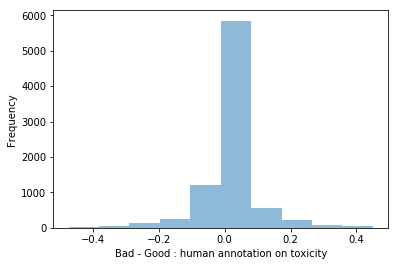

0.0260004706923 0.0308239342418 WilcoxonResult(statistic=2823803.5, pvalue=1.3344412408900053e-05)
Bad - Good < 0 1662
Bad - Good > 0 1849
Bad - Good == 0 4875


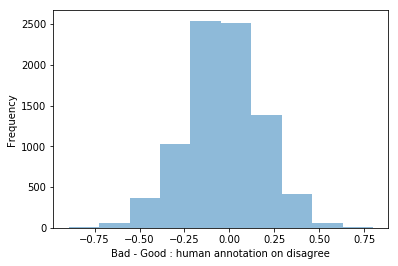

0.220091616454 0.186359551232 WilcoxonResult(statistic=12613601.5, pvalue=1.8384250123401934e-45)
Bad - Good < 0 4448
Bad - Good > 0 3416
Bad - Good == 0 522


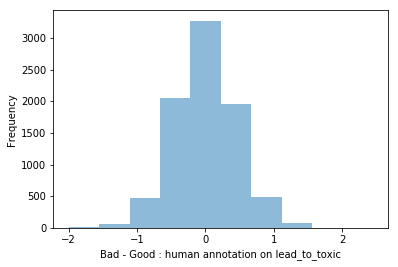

-1.48789161861 -1.49012733199 WilcoxonResult(statistic=15306526.0, pvalue=0.42681049786510439)
Bad - Good < 0 3954
Bad - Good > 0 3911
Bad - Good == 0 521


In [29]:
for var in ['toxicity', 'disagree', 'lead_to_toxic']:
    all_good = conv_df[conv_df['class'] == 1]
    all_good['%s_gap'%(var)] = all_good.apply(lambda x: conv_df.loc[x['matched_id']]['%s_score'%(var)] - x['%s_score'%(var)], axis=1)
    plt.figure()
    all_good['%s_gap'%(var)].plot.hist(alpha=0.5)
    plt.xlabel('Bad - Good : human annotation on %s'%(var))
    plt.show()
    good = conv_df[conv_df['class'] == 1]['%s_score'%(var)].values.tolist()
    bad = conv_df[conv_df['class'] == 0]['%s_score'%(var)].values.tolist()
    print(np.mean(good), np.mean(bad), scipy.stats.wilcoxon(good, bad))
    print('Bad - Good < 0', len(all_good[all_good['%s_gap'%(var)] < 0]))
    print('Bad - Good > 0', len(all_good[all_good['%s_gap'%(var)] > 0]))
    print('Bad - Good == 0', len(all_good[all_good['%s_gap'%(var)] == 0]))

In [33]:
test = {}
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/baks/never_seen.json'%(constraint)) as f:
    for line in f:
        conv_id, clss, conversation = json.loads(line)
        test[conv_id] = True

In [107]:
trainlst = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/train_cleaned_verified.json'%(constraint)) as w:
    for line in w:
        conv_id, clss, conversation = json.loads(line)
        trainlst.append(conv_id)

In [109]:
conv_df = conv_df.loc[trainlst]

In [34]:
left = []
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/test_verified.json'%(constraint), 'w') as w:
    for conv in cleaned_data:
        conv_id, clss, conversation = conv
        if not(conv_id in verified_pairs):
            continue
        if not(conv_id in test):
            left.append(conv)
        else:
            w.write(json.dumps(conv) + '\n')
print(len(left))
with open('/scratch/wiki_dumps/expr_with_matching/%s/data/train_verified.json'%(constraint), 'w') as w:
    for conv in left:
        w.write(json.dumps(conv) + '\n')

16880


# Classifier using human features

In [10]:
conv_df.columns

Index(['class', 'matched_id', 'page_title', 'disagree', 'disagree_score',
       'lead_to_toxic_score', 'likely2toxic', 'no_annotators', 'not_disagree',
       'not_sure2toxic', 'not_sure_disagree', 'not_sure_toxic', 'not_toxic',
       'toxic', 'toxicity_score', 'unlikely2toxic', 'very_likely2toxic',
       'very_unlikey2toxic'],
      dtype='object')

In [11]:
def documents2feature_vectors(human_features):
    fks = False
    X, y = [], []
    cnt = 0
    max_X = {}
    print(human_features[0].keys())
    matched_pairs = defaultdict(list)
    for dic in human_features:
        conversation = {}
        matched_pairs[dic['page_title']].append(cnt)

        for key in ['toxic', 'disagree']:
            conversation['proportion_' + key] = dic[key] / dic['no_annotators']
            conversation['proportion_not_sure_' + key] = dic['not_sure_'+key] / dic['no_annotators']
            conversation['average_' + key] = dic[key] / (dic[key] + dic['not_' + key])
        points = [1, 2, -1, -2]
        """
        conversation['average_likelihood'] = 0
        for ind, key in enumerate(['likely', 'very_likely', 'unlikely', 'very_unlikey']):
            conversation['proportion_' + key] = dic[key + '2toxic'] / dic['no_annotators']
            conversation['average_likelihood'] += dic[key+'2toxic'] *points[ind]
        conversation['average_likelihood'] /= dic['no_annotators']
        """
        clss = dic['class']
        fs = conversation
        if not fks:
            fks = sorted(fs.keys())
            for f in fks:
                max_X[f] = fs[f]
        fv = [fs[f] for f in fks]
        for f in fks:
            max_X[f] = max(max_X[f], fs[f])
        if cnt % 1000 == 0:
            print(cnt)
        cnt += 1
        X.append(fv)
        y.append(clss)
    for fv in X:
        for ind, f in enumerate(fks):
            if max_X[f] == 0: 
                continue
            fv[ind] /= max_X[f]
    X = csr_matrix(np.asarray(X))
    y = np.asarray(y)
    return X, y, fks, list(matched_pairs.values())

In [12]:
X, y, feature_names, matched_pairs = documents2feature_vectors(list(conv_df.T.to_dict().values()))

dict_keys(['class', 'matched_id', 'page_title', 'disagree', 'disagree_score', 'lead_to_toxic_score', 'likely2toxic', 'no_annotators', 'not_disagree', 'not_sure2toxic', 'not_sure_disagree', 'not_sure_toxic', 'not_toxic', 'toxic', 'toxicity_score', 'unlikely2toxic', 'very_likely2toxic', 'very_unlikey2toxic'])
0


In [13]:
def train_svm(X, y, C_svm, matched_pairs):

    # For good luck

    print("Fitting")
    tuned_parameters = [#{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'C': [a * C_svm for a in [1, 2, 3, 5, 7, 8, 9]]}]
    train_indices = []
    test_indices = []
    y_l = len(y)
    for pair in matched_pairs:
        train = []
        test = []
        for ind in range(y_l):
            if ind in pair:
                test.append(ind)
            else:
                train.append(ind)
        train_indices.append(train)
        test_indices.append(test)
    print(len(train_indices), len(test_indices))
   # print([len(t) for t in test_indices])
    lpo = zip(train_indices, test_indices)
    clf = GridSearchCV(svm.LinearSVC(), tuned_parameters, cv=lpo, scoring = 'accuracy')
    clf.fit(X, y)
    
 #   logreg = GridSearchCV(linear_model.LogisticRegression(), linear_tuned_parameters, cv=lpo, scoring= 'accuracy')
 #   logreg.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    cur = 0
    best_scores = []
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f for %r"
              % (mean_score, params), scipy.stats.sem(scores))
        if mean_score > cur:
            best_scores = scores
            cur = mean_score
    print(cur)
    return best_scores
    
 #   for params, mean_score, scores in logreg.grid_scores_:
 #       print("%0.3f (+/-%0.03f) for %r"
 #             % (mean_score, scores.std() * 1.96, params))

#    print(scores.mean())
#    print scores

In [14]:
human_p = train_svm(X, y, 0.001, matched_pairs)

Fitting
353 353
Best parameters set found on development set:

LinearSVC(C=0.005, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Grid scores on development set:

0.532 for {'C': 0.001} 0.0169128598058
0.546 for {'C': 0.002} 0.0174638463356
0.543 for {'C': 0.003} 0.0173891743396
0.558 for {'C': 0.005} 0.0175924905164
0.557 for {'C': 0.007} 0.0176267317678
0.558 for {'C': 0.008} 0.0176753589309
0.558 for {'C': 0.009000000000000001} 0.0176753589309
0.557989690722


/home/yiqing/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [15]:
with open('human_p.json', 'w') as f:
    json.dump(list(human_p), f)

In [128]:
def plot_coefficients(classifier, feature_names, top_neg_features, top_pos_features):
    coef = classifier.coef_.ravel()
    print(coef)
    top_positive_coefficients = np.argsort(coef)[-top_neg_features:]
    top_negative_coefficients = np.argsort(coef)[:top_pos_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange((top_pos_features + top_neg_features)), coef[top_coefficients], color=colors, alpha=0.5)
    names = np.array(feature_names)
    plt.xticks(np.arange(0, (top_pos_features + top_neg_features)), names[top_coefficients], rotation=60, ha='right')
    plt.title('Top Positive and Negative Features')
    plt.show()
    return list(names[top_positive_coefficients]), list(names[top_negative_coefficients])

[-0.06579943 -0.08426909 -0.09197855 -0.06094589 -0.05309516 -0.0290337
 -0.00674611 -0.09105681 -0.02602349 -0.02785159  0.00781402]


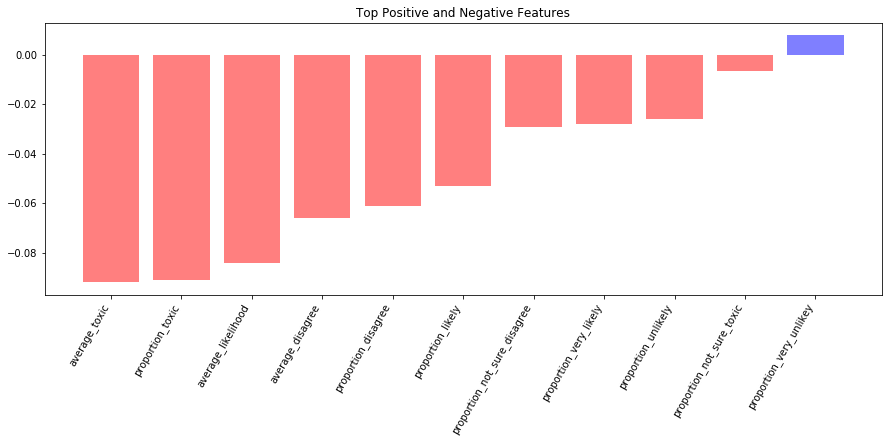

In [135]:
classifier = linear_model.LogisticRegression(C=0.005)
classifier.fit(X, y)
top_pos, top_neg= plot_coefficients(classifier, feature_names, 10, 1)

# Annotator Agreement

In [41]:
def add_row_to_coincidence(o, row, columns):
    m_u = row.sum(1)
    for i in columns:
        for j in columns:
            if i == j:
                o[i][j] = o[i][j] + row[i]*(row[i]-1)/(m_u-1)
            else:
                o[i][j] = o[i][j] + row[i]*row[j]/(m_u-1)
    return o

def make_coincidence_matrix(df, columns):
    df = df[columns]
    n = df.shape[0]
    num_cols = len(columns)
    o = pd.DataFrame(np.zeros((num_cols,num_cols)), index = columns, columns=columns)
    for i in range(n):
        o = add_row_to_coincidence(o, df[i:i+1], columns)
    return o

def binary_distance(i,j):
    return i!=j

def interval_distance(i,j):
    return (int(i)-int(j))**2

def e(n, i, j):
    if i == j:
        return n[i]*(n[i]-1)/sum(n)-1
    else:
        return n[i]*n[j]/sum(n)-1

def D_e(o, columns, distance):
    n = o.sum(1)
    output = 0
    for i in columns:
        for j in columns:
            output = output + e(n,i,j)*distance(i,j)
    return output

def D_o(o, columns, distance):
    output = 0
    for i in columns:
        for j in columns:
            output = output + o[i][j]*distance(i,j)
    return output

def Krippendorf_alpha(df, columns, distance = binary_distance, o = None):
    if o is None:
        o = make_coincidence_matrix(df, columns)
    d_o = D_o(o, columns, distance)
    d_e = D_e(o, columns, distance)
    return (1 - d_o/d_e)

In [51]:
TOXIC_COLUMNS = ['not_toxic_job2', 'toxic_job2','not_sure_toxic_job2']

total = conv_df[['not_toxic_job2', 'toxic_job2','not_sure_toxic_job2']]
total = total.fillna(int(0)).reset_index()
total['sum'] = total['not_toxic_job2'] + total['toxic_job2'] + total['not_sure_toxic_job2']
#total = total[total['sum'] ==20]

print(len(total[total['sum'] == 5]) / len(total))

#total = total[total['sum'] == 5]

total['toxic_job2'] = total.apply(lambda x: int(x['toxic_job2']), axis=1)
total[['sum']].plot.hist

n,bins,batches = plt.hist(total['not_toxic_job2'])

#print(len(total[total['not_toxic_job2'] > 20]) / len(total))

#plt.show()

#total = total[~(total['_unit_id'].isin(_excluded))]

print('All Annotator Agreement: Number of Examples : %d, Kalpha : %f'%(len(total), Krippendorf_alpha(total, TOXIC_COLUMNS)))
print('5 Annotator Agreement: Number of Examples : %d, Kalpha : %f'%(len(total[total['sum'] == 5]),  Krippendorf_alpha(total[total['sum'] == 5], TOXIC_COLUMNS)))
print('20 Annotator Agreement: Number of Examples : %d, Kalpha : %f'%(len(total[total['sum'] == 20]), Krippendorf_alpha(total[total['sum'] == 20], TOXIC_COLUMNS)))


0.2306910569105691
All Annotator Agreement: Number of Examples : 1968, Kalpha : 0.360666
5 Annotator Agreement: Number of Examples : 454, Kalpha : 0.651448
20 Annotator Agreement: Number of Examples : 1189, Kalpha : 0.264007


In [60]:
TOXIC_COLUMNS = ['not_toxic_job2', 'toxic_job2','not_sure_toxic_job2']

kalphas = []
for ind in range(10):
    total = conv_df[['not_toxic_job2', 'toxic_job2','not_sure_toxic_job2']]

    new_total = []
    for index, row in total.iterrows():
        s = row['not_toxic_job2'] + row['toxic_job2'] + row['not_sure_toxic_job2']
        if s > 5:
            al = [0] * int(row['not_toxic_job2']) + [1] * int(row['toxic_job2']) + [2] * int(row['not_sure_toxic_job2'])
            picked = random.sample(al, 5)
            entries = ['not_toxic_job2', 'toxic_job2','not_sure_toxic_job2']
            new_row = {'not_toxic_job2' : 0, 'toxic_job2': 0,'not_sure_toxic_job2': 0}
            for r in picked:
                new_row[entries[r]] += 1
            new_total.append(new_row)
        else:
            new_total.append(row)
    total = pd.DataFrame(new_total)    
    total = total.fillna(int(0)).reset_index()
    total['sum'] = total['not_toxic_job2'] + total['toxic_job2'] + total['not_sure_toxic_job2']
    total['toxic_job2'] = total.apply(lambda x: int(x['toxic_job2']), axis=1)
    total[['sum']].plot.hist
    kalphas.append(Krippendorf_alpha(total, TOXIC_COLUMNS))
print(np.mean(kalphas), scipy.stats.sem(kalphas))


0.45351617284 0.00200466797891


In [164]:
TOXIC_COLUMNS = ['no_toxic', 'toxic']

no_toxic = pd.DataFrame({'no_toxic': df[df['toxic'] == 0].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
toxic = pd.DataFrame({'toxic': df[df['toxic'] == 1].groupby('_unit_id').size()}).reset_index().set_index('_unit_id')
total = toxic.join(no_toxic, how='outer')
total = total.fillna(0).reset_index()
total['sum'] = total['toxic'] + total['no_toxic']
total = total[total['sum'] ==20]

2643 0.282819056548
